# TimeEvolvingMPO - Tutorial



First, let's import TimeEvolvingMPO and some other packages we are going to use

In [1]:
import time_evolving_mpo as tempo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

and check what version of tempo we are using.

In [2]:
tempo.__version__

'0.0.3'

**Contents:**

* Example A - The Spin Boson Model
    * A.1: The Model and its Parameters
    * A.2: Create System, Spectral Density and Bath Objects
    * A.3: The TEMPO Computation

-------------------------------------------------
## Example A - The Spin Boson Model

As a first example let's try to reconstruct one of the lines in figure 2a of [Strathearn2018] (https://doi.org/10.1038/s41467-018-05617-3 or arXiv:1711.09641v3). In this example we compute the time evolution of a spin which is strongly coupled to an ohmic bath (spin-boson model). Before we go through this step by step below, let's have a brief look at the script that will do the job, just to have an idea where we are going:

100.0%  150 of  150 [########################################] 00:00:12
Elapsed time: 12.4s


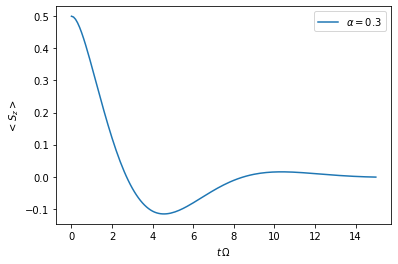

In [3]:
Omega = 1.0
omega_cutoff = 5.0
alpha = 0.3

system = tempo.System(0.5 * Omega * tempo.operators.sigma("x"))
correlations = tempo.PowerLawSD(alpha=alpha, 
                                zeta=1, 
                                cutoff=omega_cutoff, 
                                cutoff_type='exponential', 
                                max_correlation_time=8.0)
bath = tempo.Bath(0.5 * tempo.operators.sigma("z"), correlations)
tempo_parameters = tempo.TempoParameters(dt=0.1, dkmax=30, epsrel=10**(-5))

dynamics = tempo.tempo_compute(system=system,
                               bath=bath,
                               initial_state=tempo.operators.spin_dm("up"),
                               start_time=0.0,
                               end_time=15.0,
                               parameters=tempo_parameters)
t, s_z = dynamics.expectations(0.5*tempo.operators.sigma("z"), real=True)

plt.plot(t, s_z, label=r'$\alpha=0.3$')
plt.xlabel(r'$t\,\Omega$')
plt.ylabel(r'$<S_z>$')
plt.legend()

### A.1: The Model and its Parameters 
We consider a system Hamiltonian
$$ H_{S} = \frac{\Omega}{2} \hat{\sigma}_x \mathrm{,}$$
a bath Hamiltonian
$$ H_{B} = \sum_k \omega_k \hat{b}^\dagger_k \hat{b}_k  \mathrm{,}$$
and an interaction Hamiltonian
$$ H_{I} =  \frac{1}{2} \hat{\sigma}_z \sum_k \left( g_k \hat{b}^\dagger_k + g^*_k \hat{b}_k \right) \mathrm{,}$$
where $\hat{\sigma}_i$ are the Pauli operators, and the $g_k$ and $\omega_k$ are such that the spectral density $J(\omega)$ is
$$ J(\omega) = \sum_k |g_k|^2 \delta(\omega - \omega_k) = 2 \, \alpha \, \omega \, \exp\left(-\frac{\omega}{\omega_\mathrm{cutoff}}\right) \mathrm{.} $$
Also, let's assume the initial density matrix of the spin is the up state
$$ \rho(0) = \begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix} $$ and the bath is initially at zero temperature.

For the numerical simulation it is advisable to choose a characteristic frequency and express all other physical parameters in terms of this frequency. Here, we choose $\Omega$ for this and write:
    
* $\Omega = 1.0 \Omega$
* $\omega_c = 5.0 \Omega$
* $\alpha = 0.3$

In [4]:
Omega_A = 1.0
omega_cutoff_A = 5.0
alpha_A = 0.3

### A.2: Create System, Spectral Density and Bath Objects

To input the operators you can simply use numpy matrices. For the most common operators you can, more conveniently, use the `tempo.operators` module:

In [5]:
tempo.operators.sigma("x")

array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])

In [6]:
tempo.operators.spin_dm("up")

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

#### System
$$ H_{S} = \frac{\Omega}{2} \hat{\sigma}_x \mathrm{,}$$

In [7]:
system_A = tempo.System(0.5 * Omega_A * tempo.operators.sigma("x"))

#### Correlations
$$ J(\omega) = 2 \, \alpha \, \omega \, \exp\left(-\frac{\omega}{\omega_\mathrm{cutoff}}\right) $$

Because the spectral density is of the standard power-law form,
$$ J(\omega) = 2 \alpha \frac{\omega^\zeta}{\omega_c^{\zeta-1}} X(\omega,\omega_c) $$
with $\zeta=1$ and $X$ of the type ``'exponential'`` we define the spectral density with:

In [8]:
correlations_A = tempo.PowerLawSD(alpha=alpha_A, 
                                  zeta=1, 
                                  cutoff=omega_cutoff_A, 
                                  cutoff_type='exponential', 
                                  max_correlation_time=8.0)

#### Bath
The bath couples with the operator $\frac{1}{2}\hat{\sigma}_z$ to the system.

In [9]:
bath_A = tempo.Bath(0.5 * tempo.operators.sigma("z"), correlations_A)

### A.3: The TEMPO Computation

Now, that we have the system and the bath objects ready we can compute the dynamics of the spin starting in the up state, from time $t=0$ to $t=15\,\Omega^{-1}$

In [10]:
dynamics_A_1 = tempo.tempo_compute(system=system_A,
                                   bath=bath_A,
                                   initial_state=tempo.operators.spin_dm("up"),
                                   start_time=0.0,
                                   end_time=15.0,
                                   tollerance=1.0e-2)

/data/git/tempoIncubatorAdmin/time_evolving_mpo/tempo.py:485: UserWarning: Estimating parameters for TEMPO computation. No guarantie that resulting TEMPO computation converges towards the correct dynamics! Please refere to the TEMPO documentation and check convergence by varying the parameters for TEMPO manually.
  warnings.warn(GUESS_WARNING_MSG, UserWarning)


100.3%  301 of  300 [########################################] 00:00:32
Elapsed time: 32.4s


and plot the result:

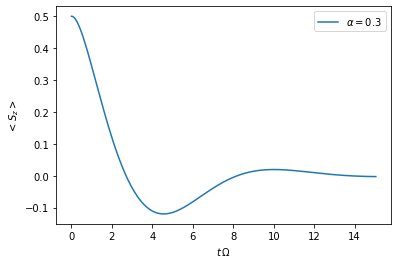

In [11]:
t_A_1, z_A_1 = dynamics_A_1.expectations(0.5*tempo.operators.sigma("z"), real=True)
plt.plot(t_A_1, z_A_1, label=r'$\alpha=0.3$')
plt.xlabel(r'$t\,\Omega$')
plt.ylabel(r'$<S_z>$')
plt.legend()

Yay! This looks like the plot in figure 2a [Strathearn2018].

#### TEMPO Parameters

Let's have a look at the above warning. It said:

```
WARNING: Estimating parameters for TEMPO calculation. No guarantie that resulting TEMPO calculation converges towards the correct dynamics! Please refere to the TEMPO documentation and check convergence by varying the parameters for TEMPO manually.
```
We got this message because we didn't tell the package what parameters to use for the TEMPO computation, but instead only specified a `tollerance`. The package tries it's best by using the function `tempo.guess_tempo_parameters()` to find parameters that are appropriate for the spectral density and system objects given.

In [12]:
parameters = tempo.guess_tempo_parameters(system=system_A,
                                          bath=bath_A,
                                          start_time=0.0,
                                          end_time=15.0)
print(parameters)

----------------------------------------------
TempoParameters object: Roughly estimated parameters
 Estimated with 'guess_tempo_parameters()'
  dt            = 0.04999999999999982 
  dkmax         = 76 
  epsrel        = 2.9315739257822093e-06 



/data/git/tempoIncubatorAdmin/time_evolving_mpo/helpers.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


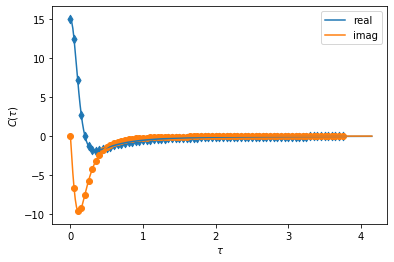

In [13]:
tempo.helpers.plot_correlations_with_parameters(bath_A.correlations, parameters)

There are **three key parameters** to a TEMPO computation:

* `dt` - Length of a time step $\delta t$,
* `dkmax` - Number of time steps $K \in \mathbb{N}$,
* `epsrel` - The maximal relative error $\epsilon_\mathrm{rel}$ in the singular value truncation.

*ToDo: short explanation of these parameters.*

You can find more on how to choose the right parameters in the documentation (*ToDo: create and link*) and the jupyter notebook `tutorials/tempo_parameters.ipnb` (*ToDo: create and link*) 

We can choose and bundle these parameters into a `TempoParameters` object.

In [14]:
tempo_parameters_A = tempo.TempoParameters(dt=0.1, dkmax=30, epsrel=10**(-5), name="my rough parameters")

In [15]:
print(tempo_parameters_A)

----------------------------------------------
TempoParameters object: my rough parameters
 __no_description__
  dt            = 0.1 
  dkmax         = 30 
  epsrel        = 1e-05 



We could feed this object into the `tempo.tempo_compute()` function to get the dynamics of the system. However, instead of that, we can split up the work that `tempo.tempo_compute()` does into several steps, which allows us to resume a computation to get later system dynamics without having to start over. For this we start with creating a `Tempo` object:

In [16]:
tempo_A = tempo.Tempo(system=system_A,
                      bath=bath_A,
                      parameters=tempo_parameters_A,
                      initial_state=tempo.operators.spin_dm("up"),
                      start_time=0.0)

We can start by computing the dynamics up to time $15.0\,\Omega^{-1}$,

In [17]:
tempo_A.compute(end_time=15.0)

100.0%  150 of  150 [########################################] 00:00:12
Elapsed time: 12.7s


then get and plot the dynamics of expecatation values,

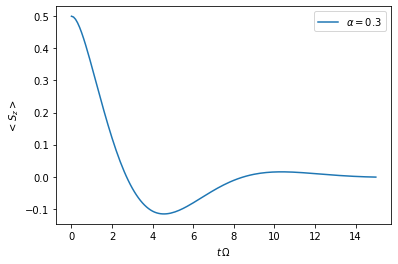

In [18]:
dynamics_A_2 = tempo_A.get_dynamics()
plt.plot(*dynamics_A_2.expectations(0.5*tempo.operators.sigma("z"),real=True), label=r'$\alpha=0.3$')
plt.xlabel(r'$t\,\Omega$')
plt.ylabel(r'$<S_z>$')
plt.legend()

then continue the computation to $25.0\,\Omega^{-1}$,

In [19]:
tempo_A.compute(end_time=25.0)

100.0%  100 of  100 [########################################] 00:00:09
Elapsed time: 9.3s


and then again get and plot the dynamics of expecatation values.

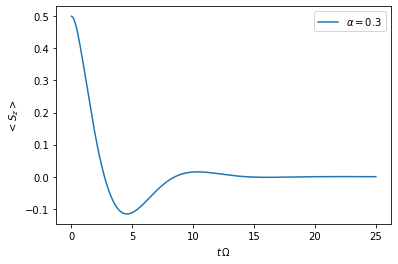

In [20]:
dynamics_A_2 = tempo_A.get_dynamics()
plt.plot(*dynamics_A_2.expectations(0.5*tempo.operators.sigma("z"),real=True), label=r'$\alpha=0.3$')
plt.xlabel(r'$t\,\Omega$')
plt.ylabel(r'$<S_z>$')
plt.legend()

-------------------------------------------------
*ToDo: More Explanation, More Examples*